<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/2_supervised-learning/DL_Sequential_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Statistics
from statsmodels.tsa.stattools import adfuller

# Data Prepocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader

# Reporting
import matplotlib.pyplot as plt

#### Data Extraction

In [2]:
url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/2_supervised-learning/HMM-SPY.csv'

In [3]:
url_btc = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/2_supervised-learning/BTC-USD.csv'

In [8]:
# Data Extraction
df = pd.read_csv(url)
useful_features = ["Open", "Adj Close", "MA_12", "MA_21", "HMM", "lrets_bench", "lrets_strat"]
df = df[useful_features]
df.head(2)

,Open,Adj Close,MA_12,MA_21,HMM,lrets_bench,lrets_strat
0,256.820007,242.321487,233.622290,238.259514,2,0.009351,0.0
1,257.559998,243.454041,234.584504,238.076622,3,0.004663,-0.0


In [6]:
# Data Extraction
df_btc = pd.read_csv(url_btc)
df.head(2)

,Date,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
0,2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
1,2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974


### Data Preprocessing

In [9]:
# Add Rolling Returns and TARGET
df["lrets_bench_roll"] = df["lrets_bench"].rolling(window=10).mean()
df["TARGET"] = df["lrets_strat"].shift(1)
df.dropna(inplace=True)
df.head()

,Open,Adj Close,MA_12,MA_21,HMM,lrets_bench,lrets_strat,lrets_bench_roll,TARGET
9,264.820007,248.068802,244.613200,238.964305,1,-0.013603,-0.003063,0.003279,-0.000604
10,264.010010,248.587906,245.479860,239.758611,1,0.002090,-0.000000,0.002553,-0.003063
11,263.209991,248.719986,246.201024,240.785478,2,0.000531,0.000000,0.002140,-0.000000
12,265.609985,250.824539,246.909612,242.198377,3,0.008426,-0.008393,0.002630,0.000000
13,263.390015,248.918198,247.364958,242.988414,2,-0.007629,0.002010,0.001829,-0.008393


In [10]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")
non_stationaries

Non-Stationary Features Found: 4


['Open', 'Adj Close', 'MA_12', 'MA_21']

In [11]:
# Convert Non-Stationary items to log
df[non_stationaries] = np.log(df[non_stationaries])

In [12]:
# Min Max Scaling
scaler = MinMaxScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
df.head(10)

,Open,Adj Close,MA_12,MA_21,HMM,lrets_bench,lrets_strat,lrets_bench_roll,TARGET
9,0.200641,0.177745,0.047211,0.000000,0.333333,0.504813,0.532233,0.681136,-0.000604
10,0.196512,0.180398,0.052376,0.004967,0.333333,0.582264,0.595795,0.664534,-0.003063
11,0.192422,0.181072,0.056659,0.011364,0.666667,0.574569,0.595795,0.655088,-0.000000
12,0.204655,0.191766,0.060856,0.020121,1.000000,0.613533,0.421644,0.666302,0.000000
13,0.193344,0.182083,0.063546,0.024995,0.666667,0.534293,0.637505,0.647975,-0.008393
14,0.196053,0.180398,0.065648,0.029236,0.666667,0.565394,0.688358,0.658932,0.002010
15,0.202065,0.200332,0.069629,0.034699,1.000000,0.649466,0.783571,0.668788,0.004461
16,0.214262,0.211430,0.075411,0.040193,0.666667,0.615104,0.799558,0.683255,0.009050
17,0.227497,0.212040,0.079876,0.045630,1.000000,0.574323,0.592722,0.667074,0.009820
18,0.227298,0.220938,0.084908,0.053188,0.666667,0.606549,0.774013,0.652873,-0.000148


In [13]:
# Split X and Y data
X_data = df.iloc[:, : -1].values
y_data = df.iloc[:, -1].values
print(f"X_data: \n {X_data[:1]} \n")
print(f"y: \n {y_data[0:5]} \n")

X_data: 
 [[0.20064088 0.1777452  0.0472111  0.         0.33333333 0.50481327
  0.53223262 0.6811359 ]] 

y: 
 [-0.00060402 -0.00306336 -0.          0.         -0.00839313] 



### Data Sequencing

In [14]:
# split a univariate sequence into samples
def split_sequence(input_data, n_steps):

    X = list()
    for i in range(len(input_data)):

        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the sequence
        if end_ix > len(input_data)-1:
            break

        # gather input and output parts of the pattern
        seq_x = input_data[i:end_ix, :-1]

        # gather input a
        X.append(seq_x)
    return np.array(X)

In [15]:
# choose a number of time steps in each sample window
n_timesteps = 8

# split X into sequence samples
X = split_sequence(X_data, n_timesteps)

# Adjust y to start at the right point
y = y_data[n_timesteps: ]

In [16]:
# summarize and check the X sequence
print("")
print("X summary:")
counts = 0
for i in range(len(X)):
    counts += 1
    if counts <=2:
        print(X[i])
    else:
        break

# summarize and check the y sequence
print("")
print("y summary:")
counts = 0
for i in range(len(y)):
    counts += 1
    if counts <=2:
        print(y[i])
    else:
        break


X summary:
[[0.20064088 0.1777452  0.0472111  0.         0.33333333 0.50481327
  0.53223262]
 [0.19651226 0.1803982  0.05237563 0.00496689 0.33333333 0.58226423
  0.59579465]
 [0.19242205 0.18107234 0.05665925 0.01136369 0.66666667 0.57456887
  0.59579465]
 [0.20465531 0.191766   0.06085597 0.02012078 1.         0.61353273
  0.42164448]
 [0.19334353 0.18208334 0.06354648 0.02499517 0.66666667 0.53429341
  0.63750451]
 [0.19605276 0.1803982  0.06564806 0.02923554 0.66666667 0.56539409
  0.68835771]
 [0.20206512 0.20033197 0.06962947 0.0346993  1.         0.64946563
  0.7835711 ]
 [0.21426199 0.21142959 0.07541099 0.04019253 0.66666667 0.61510364
  0.79955837]]
[[0.19651226 0.1803982  0.05237563 0.00496689 0.33333333 0.58226423
  0.59579465]
 [0.19242205 0.18107234 0.05665925 0.01136369 0.66666667 0.57456887
  0.59579465]
 [0.20465531 0.191766   0.06085597 0.02012078 1.         0.61353273
  0.42164448]
 [0.19334353 0.18208334 0.06354648 0.02499517 0.66666667 0.53429341
  0.63750451]
 [0

In [17]:
class dataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.X.shape[0]
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    def __len__(self):
        return self.length

# Trainset
trainset = dataset(X, y)

# Data Loader
trainloader = DataLoader(trainset, batch_size=20, shuffle=False)

In [18]:
print(trainset.X.shape)
trainset.X[0:3]

torch.Size([835, 8, 7])


tensor([[[0.2006, 0.1777, 0.0472, 0.0000, 0.3333, 0.5048, 0.5322],
         [0.1965, 0.1804, 0.0524, 0.0050, 0.3333, 0.5823, 0.5958],
         [0.1924, 0.1811, 0.0567, 0.0114, 0.6667, 0.5746, 0.5958],
         [0.2047, 0.1918, 0.0609, 0.0201, 1.0000, 0.6135, 0.4216],
         [0.1933, 0.1821, 0.0635, 0.0250, 0.6667, 0.5343, 0.6375],
         [0.1961, 0.1804, 0.0656, 0.0292, 0.6667, 0.5654, 0.6884],
         [0.2021, 0.2003, 0.0696, 0.0347, 1.0000, 0.6495, 0.7836],
         [0.2143, 0.2114, 0.0754, 0.0402, 0.6667, 0.6151, 0.7996]],

        [[0.1965, 0.1804, 0.0524, 0.0050, 0.3333, 0.5823, 0.5958],
         [0.1924, 0.1811, 0.0567, 0.0114, 0.6667, 0.5746, 0.5958],
         [0.2047, 0.1918, 0.0609, 0.0201, 1.0000, 0.6135, 0.4216],
         [0.1933, 0.1821, 0.0635, 0.0250, 0.6667, 0.5343, 0.6375],
         [0.1961, 0.1804, 0.0656, 0.0292, 0.6667, 0.5654, 0.6884],
         [0.2021, 0.2003, 0.0696, 0.0347, 1.0000, 0.6495, 0.7836],
         [0.2143, 0.2114, 0.0754, 0.0402, 0.6667, 0.6151, 0.

In [19]:
trainset.y[:10]

tensor([ 0.0098, -0.0001,  0.0086,  0.0013, -0.0068, -0.0081,  0.0000,  0.0045,
         0.0095, -0.0046])

### Construct Neural Network

In [20]:
from torch import nn
from torch.autograd import Variable
class LSTM_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Net, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Hidden layers
        self.layer_dim = layer_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, 5)

        # Fully connected layer
        self.fc2 = nn.Linear(5, output_dim)

    def forward(self, x):

        # Initialize Hidden State with zeros (layer dim = 1, x.size = 64)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # Initialize Cell State with zeros
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

#         # Outputs - Classification
#         out, (hn, cn) = self.lstm(x, (h0, c0))
#         out = self.fc1(out[:, -1, :])
#         out = torch.sigmoid(self.fc2(out))

        # Regression - Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_dim)
        out = self.fc1(h_out)
        out = self.fc2(out)

        return out

In [21]:
# Initialize model
input_dim = X.shape[2]
hidden_dim = 100
layer_dim = 1
output_dim = 1
model = LSTM_Net(input_dim, hidden_dim, layer_dim, output_dim)
print(f"Model Parameters: {len(list(model.parameters()))}")

Model Parameters: 8


In [22]:
# Review Model Structure
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 7])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([5, 100])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])


### Train LSTM Neural Network

In [25]:
epochs = 1000

# # for classification
# criterion = nn.BCELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

# Regression
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

losses = []

iter = 0
for epoch in range(epochs):
    for i, (X_train, y_train) in enumerate(trainloader):

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Calculate loss
        loss = criterion(outputs, y_train.unsqueeze(dim=1))

        # Backward propegation
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Increment iteration
        iter += 1

    # Track progress
    if iter % 100 == 0:
        print(f"Loss: {loss}")
        losses.append(loss.detach())

Loss: 1.8710585436565452e-07
Loss: 8.359124308299215e-07
Loss: 1.8080634163197828e-06
Loss: 9.42205369938165e-05
Loss: 3.305995051050559e-05
Loss: 3.018952611455461e-06
Loss: 2.749016630332335e-06
Loss: 9.765373079062556e-07
Loss: 6.387741535718305e-08
Loss: 3.15461488753499e-06
Loss: 9.741629583004396e-07
Loss: 1.6893936845008284e-06
Loss: 3.9663380135834814e-08
Loss: 6.42723807686707e-06
Loss: 2.3821796730771894e-06
Loss: 6.539359219459584e-06
Loss: 7.471587650798028e-07
Loss: 1.375675651615893e-06
Loss: 6.392346563188767e-07
Loss: 3.6462720345298294e-06


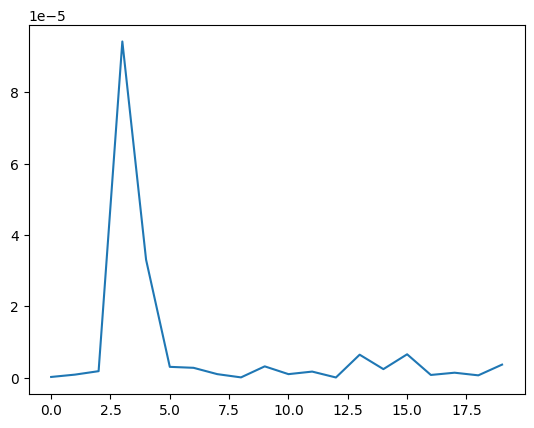

In [26]:
# Review losses
plt.plot(losses)
plt.show()